# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

**Warning 1**: You have 2 weeks for this assignemnt.  **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hand.

### Task 1 <a id="task1"></a> (0.5 points)

Here you should implement the function `H()` which calculates impurity criterion. We will be training regression tree, and will take mean absolute deviation as impurity criterion.

* You cannot use loops
* If `y` is empty, the function should return 0

In [43]:
def H(y):
    """
    Calculate impurity criterion

    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if y.size == 0:
        return 0

    # https://www.google.com/search?q=mean+absolute+deviation+formula&si=ALGXSlak8K6umOBV_MCwx-aeRh6TYd9RdMu4ntu98_aLkwrWoYxNYLA3nEbi2NNy024Eu-d1h11N3a7HoP2_nwEyJMR0W6532y3T1eLPRt0JWlMCRHKloURuR3in980Hj9cxnwrF6FYAh_lWYofS6mQKgdf5hDRsmA%3D%3D&ictx=1&ved=2ahUKEwj3qcqMjc2CAxWeRPEDHSmnAW4Qw_oBegQIRRAC
    return np.mean(np.abs(y - np.mean(y)))

In [44]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote:
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [45]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node
    y : ndarray
        array of target values in the node
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    X_f = X[:, j]
    y_left = y[X_f < t]
    y_right = y[X_f >= t]

    return y_left.size / y.size * H(y_left) + y_right.size / y.size * H(y_right)

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Also, please add `min_samples_leaf` parameter to your class

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [46]:
class Node(object):
    """
    Class for a decision tree node.

    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float

    column: int

    depth: int

    prediction: float
        prediction of the target value in the node
        (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """
    def __init__(self):
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None

    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'. \
            format(self.column, self.threshold, self.prediction)
        return node_desc

In [47]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf

    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node.
        Try all features and thresholds.

        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.

        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child.
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child.
        """

        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)

        for j in range(X.shape[1]):
          X_f = X[:, j]
          for t in np.unique(X_f):
              val = Q(X, y, j, t)
              y_right = y[X_f >= val]
              y_left = y[X_f < val]
              if (val < best_cost and y_right.size >= self.min_samples_leaf
                  and y_left.size >= self.min_samples_leaf):
                best_cost = val
                best_split_column = j
                best_threshold = t

        if best_split_column is not None:
            X_f = X[:, best_split_column]
            X_left = X[X_f < best_threshold]
            y_left = y[X_f < best_threshold]
            X_right = X[X_f >= best_threshold]
            y_right = y[X_f >= best_threshold]

            self.split_columns_[best_split_column] = self.split_columns_.get(best_split_column, []) + [best_threshold]
            return best_split_column, best_threshold, X_left, y_left, X_right, y_right
        return [None] * 6

    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth`,
        `min_samples_split` parameters for a given node.

        Parameters
        ----------
        node : Node,

        y : ndarray, shape (n_objects, )
            Object labels.

        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:
            return True
        if len(y) < self.min_samples_split:
            return True
        return False

    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects
        y : ndarray, shape (n_objects)
            Labels
        """

        if self.is_terminal(node, y):
            node.is_terminal = True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if best_split_column is None:
            node.is_terminal = True
            return

        node.left = Node()
        node.right = Node()
        node.left.depth = node.depth + 1
        node.right.depth = node.depth + 1
        node.left.prediction = np.mean(y_left)
        node.right.prediction = np.mean(y_right)
        node.threshold = best_threshold
        node.column = best_split_column

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        self.split_columns_ = {}
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]

        # Initialize the tree (root node)
        self.tree_ = Node()
        self.tree_.depth = 1
        self.tree_.prediction = np.mean(y)

        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self

    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get
            predictions of the proper child

        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        if node.is_terminal:
            return node.prediction

        if (x[node.column] < node.threshold):
            return self.get_prediction(node.left, x)
        return self.get_prediction(node.right, x)

    def predict(self, X):
        """
        Get prediction for each object in X

        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')

        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [48]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

In [49]:
import graphviz

def get_node_name(node):
  return f"{node.depth}{hash(node)}"

def vt(graph, parent_node, child_node, columns_names, is_left):
    if (child_node is None):
      return

    if parent_node is None:
      if (child_node.is_terminal):
          graph.node(get_node_name(child_node), str(child_node))
          return

      graph.node(get_node_name(child_node), f"{columns_names[child_node.column]} >= {child_node.threshold:.2f}")
      vt(graph, child_node, child_node.left, columns_names, True)
      vt(graph, child_node, child_node.right, columns_names, False)
      return

    if (child_node.is_terminal):
        graph.node(get_node_name(child_node), str(child_node))
        graph.edge(get_node_name(parent_node), get_node_name(child_node), label=f"{not is_left}")
        return

    graph.node(get_node_name(child_node), f"{columns_names[child_node.column]} >= {child_node.threshold:.2f}")
    graph.edge(get_node_name(parent_node), get_node_name(child_node), label=f"{not is_left}")
    vt(graph, child_node, child_node.left, columns_names, True)
    vt(graph, child_node, child_node.right, columns_names, False)

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($75\%$) and test ($25\%$). Fit Decision Tree of **depth 1, 3, 5** and make the following plots for every case:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model (tree visualization)

Compare `MAE` on train and test. Have trees overfitted?

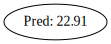

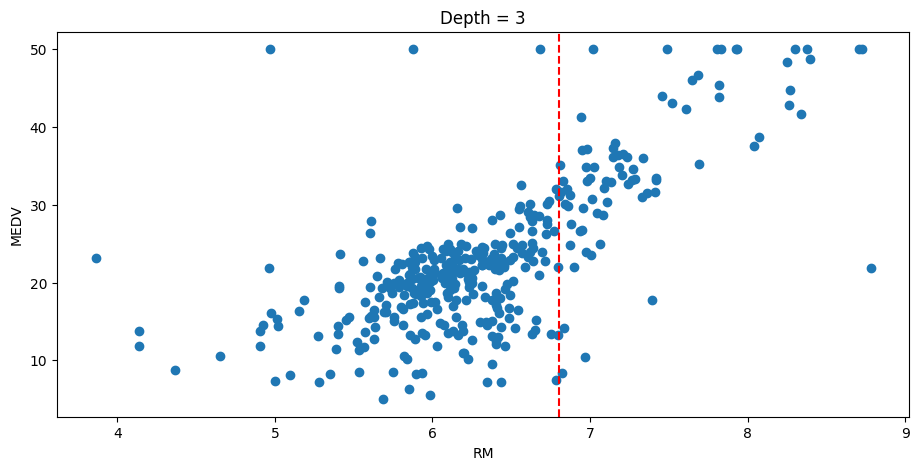

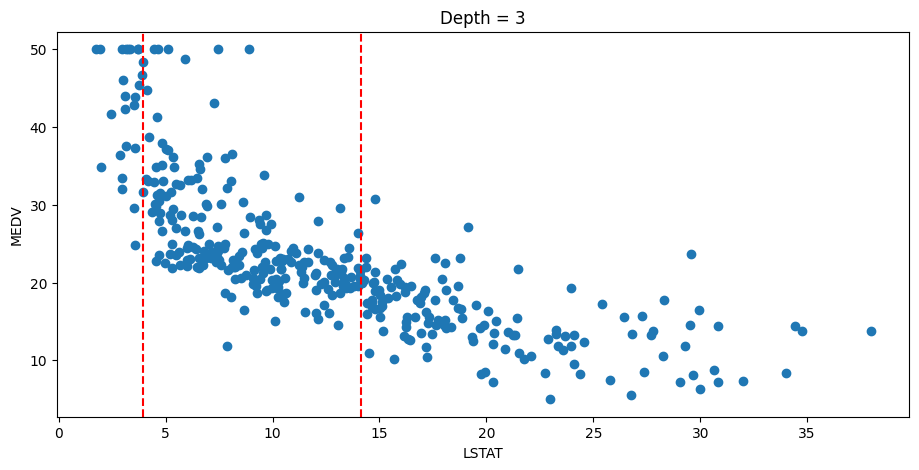

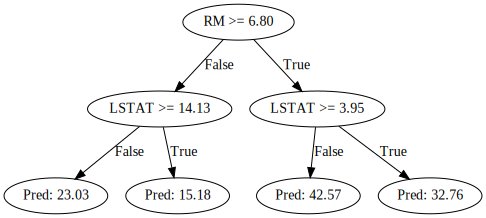

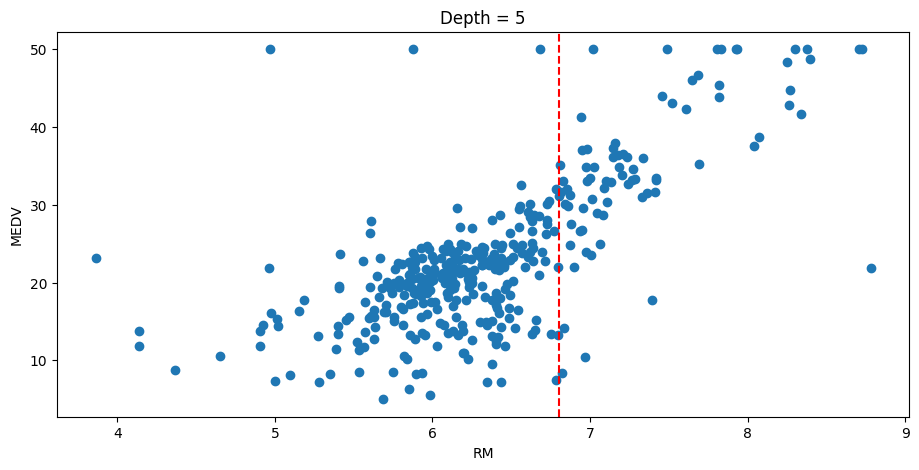

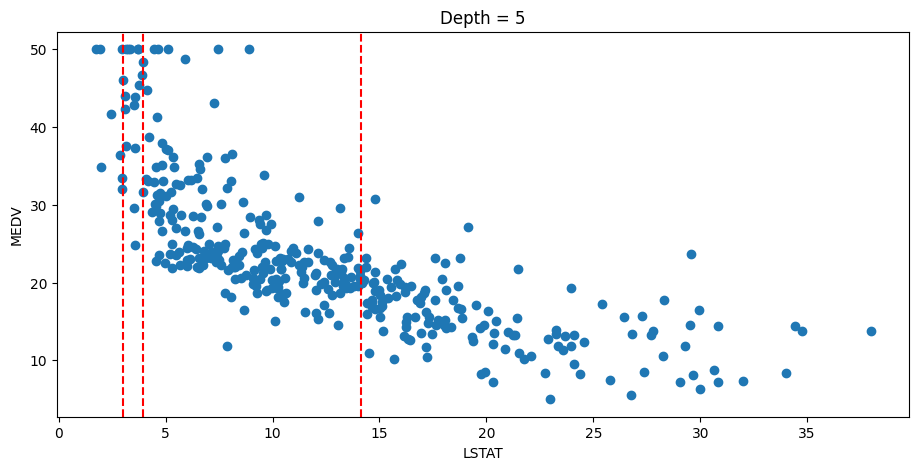

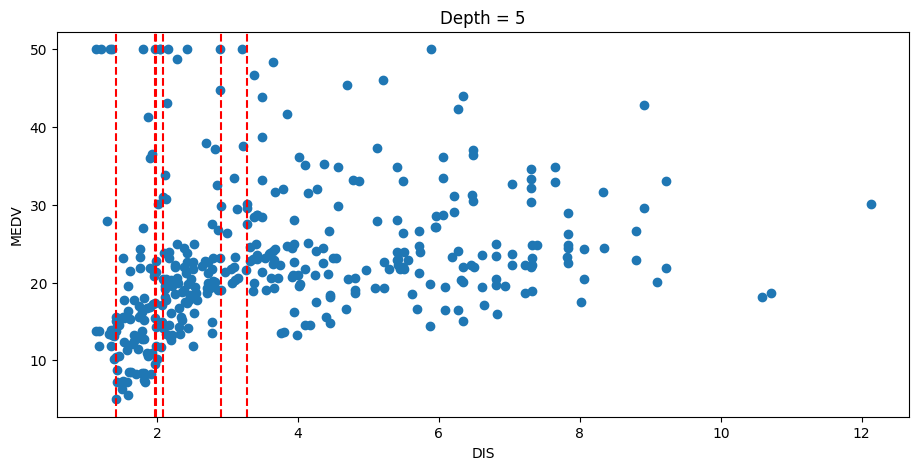

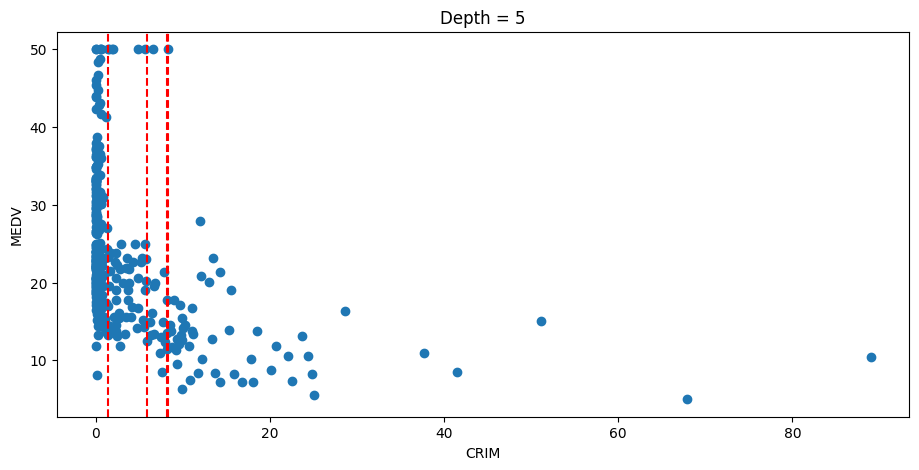

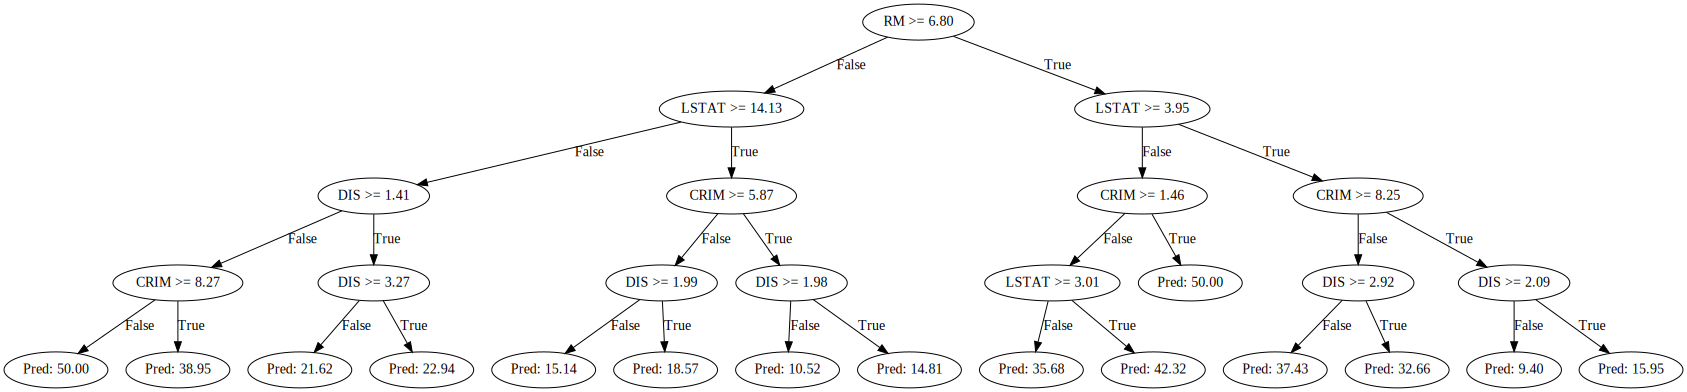

Train MAE:  [6.889290662136855, 3.840700573196252, 2.8314290698845683]
Test MAE:  [6.222778551097999, 3.696550581551779, 3.2901301076010525]


In [50]:
df = pd.read_csv(
    filepath_or_buffer="https://raw.githubusercontent.com/scikit-learn/scikit-learn/main/sklearn/datasets/data/boston_house_prices.csv",
    skiprows=1
)


from sklearn.model_selection import train_test_split
X = df.drop("MEDV", axis=1)
y = df.MEDV
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

from sklearn.tree import plot_tree
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import mean_absolute_error
import graphviz

mae_train = []
mae_test = []
for depth in range(1, 6, 2):
    clf = MyDecisionTreeRegressor(max_depth=depth)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    for feature, thresholds in clf.split_columns_.items():
        plt.scatter(X_train[X.columns[feature]], y_train)
        for threshold in thresholds:
            plt.axvline(x=threshold, color="r", linestyle='--')
        plt.xlabel(X.columns[feature])
        plt.ylabel("MEDV")
        plt.title(f"Depth = {depth}")
        plt.show()
    mae_train.append(mean_absolute_error(y_train, clf.predict(X_train)))
    mae_test.append(mean_absolute_error(y_test, prediction))
    graph = graphviz.Digraph()
    vt(graph, None, clf.tree_, X.columns, False)
    display(graph)
print("Train MAE: ", mae_train)
print("Test MAE: ", mae_test)

Train MAE:  [6.889290662136855, 3.5124363697281904, 2.3731022950108898]  
Test MAE:  [6.222778551097999, 3.533031771028621, 2.8890456467977614]

Деревья с большей глубиной сильнее переобучаются. Такой вывод можно сделать по полученным значениям MAE. Деревья переобучены тогда, когда на train значение MAE сильно ниже значения на test

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset.
- Use `GridSearchCV` to find the best hyperparameters among [`max_depth`, `min_samples_leaf`] on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset.
- Report `MAE` on test dataset and hyperparameters of the best estimator.

In [51]:
# https://github.com/darkydash/ml_hse/blob/main/week07/Seminar_07_Decision_trees_autumn23%20(1).ipynb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

clf = MyDecisionTreeRegressor()

parameters = {'max_depth': [1, 3, 5, 7, 10],
              'min_samples_leaf': [1, 5, 10, 50]}

gs = GridSearchCV(clf,
                  parameters,
                  scoring="neg_mean_absolute_error",
                  cv=5)

result = gs.fit(X_train, y_train)

In [52]:
print(result.best_params_)
clf = MyDecisionTreeRegressor(**result.best_params_)
clf.fit(X_train, y_train)

{'max_depth': 7, 'min_samples_leaf': 1}


MyDecisionTreeRegressor(max_depth=7)

In [53]:
print(f"MAE value on test with params {result.best_params_} is: {mean_absolute_error(y_test, clf.predict(X_test))}")

MAE value on test with params {'max_depth': 7, 'min_samples_leaf': 1} is: 3.025972979181438


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use the following algorithm to estimate bias and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n_iter}$
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n_iter}$, which contain all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on $X_i$s and compute predictions on $Z_i$s
4. For a given *object* $n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $n$ was in OOB)
     - variance: variance of the prediction (predictions of the algorithms, for which $n$ was in OOB)
5. Average bias^2 and variance over all the points
    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations). All other operations should be vectorized.

In [54]:
def get_bias_variance(estimator, x, y, n_iter):
    """
    Calculate bias and variance of the `estimator`.
    Using a given dataset and bootstrap with `n_iter` samples.

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in
    Returns
    -------
    bias2 : float,
        Estiamted squared bias
    variance : float,
        Estiamted variance
    """
    np.random.seed(42)
    n_samples = x.shape[0]
    n_features = x.shape[1]

    y_pred = np.empty((n_samples, n_features))
    y_pred[:] = np.nan

    for bootstarp_iter in range(n_iter):
        idx = np.random.choice(n_samples, size=n_samples, replace=True)
        X_i = x[idx]
        mask = np.ones(n_samples, dtype=bool)
        mask[idx] = False
        Z_i = x[mask]
        estimator.fit(X_i, y[idx])
        y_pred[mask, bootstarp_iter] = estimator.predict(Z_i)

    bias_sq = np.nanmean((y - np.nanmean(y_pred, axis=1))**2)
    variance = np.nanmean(np.nanvar(y_pred, axis=1))
    return bias_sq, variance

In [55]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train.values, y_train.values, 10)

(22.22743813720527, 9.772064006609709)

### Task 7 <a id="task7"></a>  (0.5 points)

Compute bias and variance for the trees with different min_samples_split. Plot how bias and variance change as min_samples_split increases.

Comment on what you observe, how does your result correspond to theory?

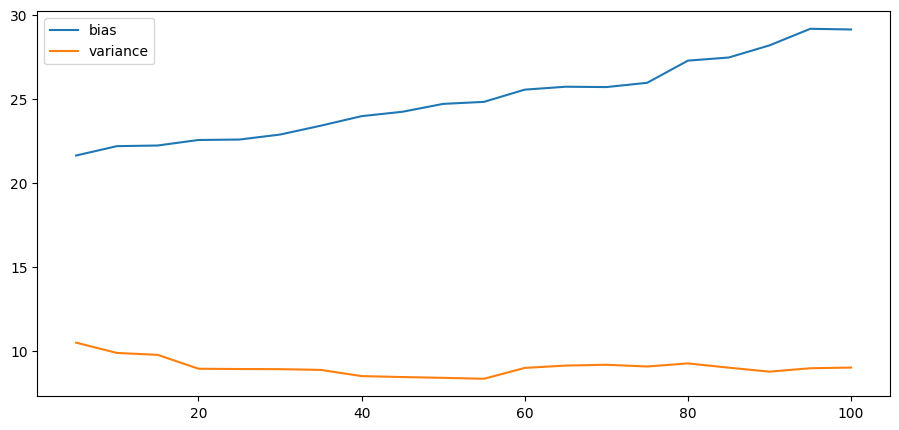

In [56]:
min_samples_split_values = [i for i in range(5, 105, 5)]
bias_values = []
var_values = []
for min_samples_split in min_samples_split_values:
    clf = MyDecisionTreeRegressor(max_depth=8, min_samples_split=min_samples_split)
    bias, variance = get_bias_variance(clf, X_train.values, y_train.values, 10)
    bias_values.append(bias)
    var_values.append(variance)

plt.plot(min_samples_split_values, bias_values, label="bias")
plt.plot(min_samples_split_values, var_values, label="variance")
plt.legend()
plt.show()

С увеличением `min_samples_split` глубина дерева тоже будет уменьшаться, так как минимальное количество объектов в промежуточных узлах должно быть всё больше и больше. По этой причине деревья недообучаются и смещение возрастает. Разброс же уменьшается, так как модели становятся менее разнообразными.

### Task 8 <a id="task8"></a>  (0.5 points)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance.

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments?
 - Do your results align with the theory? Why?

In [57]:
from sklearn.ensemble import BaggingRegressor

ensemble = BaggingRegressor(estimator=MyDecisionTreeRegressor(max_depth=8, min_samples_split=15),
                     n_estimators=10, random_state=42)

bias, variance = get_bias_variance(ensemble, X_train.values, y_train.values, 10)


print(f"Ensemble Squared Bias: {bias}")
print(f"Ensemble Variance: {variance}")

Ensemble Squared Bias: 21.576676845480193
Ensemble Variance: 3.2950237957987354


В теории использование бэггинга должно уменьшать разброс, так как увеличивается разнообразие моделей, что позволяет компенсировать ошибки при усреднении ответов. При этом значимого влияния на смещения быть не должно  

Смещение уменьшилось несильно, разброс значимо сократился  

Результаты согласуются с теорией, так как разброс сильно сокартился, а смещение изменилось несильно

# Part 2. More Ensembles

In this part we will be working with [Billionaires Statistics Dataset](https://www.kaggle.com/datasets/nelgiriyewithana/billionaires-statistics-dataset) to solve a classification task.

In [58]:
!wget https://raw.githubusercontent.com/darkydash/ml_hse/main/hw4/Billionaires%20Statistics%20Dataset.csv

--2023-11-26 14:22:39--  https://raw.githubusercontent.com/darkydash/ml_hse/main/hw4/Billionaires%20Statistics%20Dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 677819 (662K) [text/plain]
Saving to: ‘Billionaires Statistics Dataset.csv.14’

Billionaires Statis 100%[===================>] 661.93K  --.-KB/s    in 0.007s  

2023-11-26 14:22:39 (89.6 MB/s) - ‘Billionaires Statistics Dataset.csv.14’ saved [677819/677819]



In [59]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('Billionaires Statistics Dataset.csv')

le = LabelEncoder()
y = le.fit_transform(df['selfMade'])
X = df.drop('selfMade', axis=1)
X.head(5)

,rank,finalWorth,category,personName,age,country,city,source,industries,countryOfCitizenship,...,cpi_change_country,gdp_country,gross_tertiary_education_enrollment,gross_primary_education_enrollment_country,life_expectancy_country,tax_revenue_country_country,total_tax_rate_country,population_country,latitude_country,longitude_country
0,1,211000,Fashion & Retail,Bernard Arnault & family,74.0,France,Paris,LVMH,Fashion & Retail,France,...,1.1,"$2,715,518,274,227",65.6,102.5,82.5,24.2,60.7,67059887.0,46.227638,2.213749
1,2,180000,Automotive,Elon Musk,51.0,United States,Austin,"Tesla, SpaceX",Automotive,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
2,3,114000,Technology,Jeff Bezos,59.0,United States,Medina,Amazon,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
3,4,107000,Technology,Larry Ellison,78.0,United States,Lanai,Oracle,Technology,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891
4,5,106000,Finance & Investments,Warren Buffett,92.0,United States,Omaha,Berkshire Hathaway,Finance & Investments,United States,...,7.5,"$21,427,700,000,000",88.2,101.8,78.5,9.6,36.6,328239523.0,37.090240,-95.712891


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing.

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice.
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (if there are many unique values in a column, you can group them by meaning)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transform1, column_names1),
    ('name2', transform2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer.
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_tranform = make_pipeline(
                        transform_1,
                        transform_2
                        )
```

P.S. Choose your favourite way to fill missing values.

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns on the dataset.

In [60]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 34 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   personName                                  2640 non-null   object 
 4   age                                         2575 non-null   float64
 5   country                                     2602 non-null   object 
 6   city                                        2568 non-null   object 
 7   source                                      2640 non-null   object 
 8   industries                                  2640 non-null   object 
 9   countryOfCitizenship                        2640 non-null   object 
 10  organization

Используя полученную таблицу `info` и сведения к колонкам отберем признаки:
- признаки `personName`, `lastName`, `firstName` не несут информации полезной для предсказания.
- признаки `organization`, `title`, `state`, `residenceStateRegion` имеют много пропущенных значений, поэтому имеет смысл просто выкинуть их
- `birthDate`, `birthMonth`, `birthYear`, `birthDay` дублируют признак `age`
- `date` &mdash; время сбора данных, что не несет полезной информации

In [61]:
X = X.drop(columns=["personName", "lastName", "firstName", "organization", "title", "state", "residenceStateRegion", "birthDate", "birthMonth", "birthYear", "birthDay", "date"])

In [62]:
X["gdp_country"] = X["gdp_country"].str[1:]
X["gdp_country"] = X["gdp_country"].str.replace(",", "").astype("float64")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 22 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   age                                         2575 non-null   float64
 4   country                                     2602 non-null   object 
 5   city                                        2568 non-null   object 
 6   source                                      2640 non-null   object 
 7   industries                                  2640 non-null   object 
 8   countryOfCitizenship                        2640 non-null   object 
 9   status                                      2640 non-null   object 
 10  gender      

In [63]:
r = X.industries == X.category
print(r.value_counts())
X = X.drop(columns=["industries"])

True    2640
dtype: int64


In [64]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2640 entries, 0 to 2639
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rank                                        2640 non-null   int64  
 1   finalWorth                                  2640 non-null   int64  
 2   category                                    2640 non-null   object 
 3   age                                         2575 non-null   float64
 4   country                                     2602 non-null   object 
 5   city                                        2568 non-null   object 
 6   source                                      2640 non-null   object 
 7   countryOfCitizenship                        2640 non-null   object 
 8   status                                      2640 non-null   object 
 9   gender                                      2640 non-null   object 
 10  cpi_country 

In [65]:
X.country.value_counts()

United States           754
China                   523
India                   157
Germany                 102
United Kingdom           82
                       ... 
Portugal                  1
Georgia                   1
Eswatini (Swaziland)      1
Uzbekistan                1
Armenia                   1
Name: country, Length: 78, dtype: int64

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42)

# YOUR CODE HERE
categorical_pipline = make_pipeline(OneHotEncoder(drop='first'))
numeric_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"))
categorical = [col for col in X.columns if X[col].dtype == np.dtype("object")]
numeric = [col for col in X.columns if X[col].dtype != np.dtype("object")]
# define column_transformer
column_transformer = ColumnTransformer([
    ('categorical', categorical_pipline, categorical),
    ('numeric', numeric_pipeline, numeric)
])

# Transform the data
column_transformer.fit(X)
X_train = column_transformer.transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [67]:
df['selfMade'].value_counts()

True     1812
False     828
Name: selfMade, dtype: int64

Классы несбалансированы, поэтому будем использовать метрику, учитывающую такое распределние: AP (average_precision)

In [68]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score, make_scorer

scorer = make_scorer(average_precision_score, greater_is_better=True,
                             needs_threshold=True)
cv_skf = StratifiedKFold(n_splits=5)
random_state = 42
clfs = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "SVM": SVC(probability=True, random_state=random_state),
    "Logitics Regression": LogisticRegression(random_state=random_state)
}

for clf_name, clf in clfs.items():
    scores = cross_val_score(clf, X_train, y_train, cv = cv_skf, n_jobs=-1, scoring=scorer)
    print(f"{clf_name} scores: {scores} | {clf_name} mean score: {np.mean(scores)}")


Gradient Boosting scores: [0.9212842  0.9295363  0.9366401  0.92690353 0.90465402] | Gradient Boosting mean score: 0.9238036277712812
Random Forest scores: [0.92456754 0.92629346 0.91911301 0.92933138 0.92611656] | Random Forest mean score: 0.9250843905810514
Decision Tree scores: [0.81169793 0.80428679 0.8028373  0.79452158 0.77963244] | Decision Tree mean score: 0.7985952072774484
SVM scores: [0.72303368 0.80471658 0.72494215 0.71569542 0.62573247] | SVM mean score: 0.7188240592785277
Logitics Regression scores: [0.72927097 0.74601203 0.74213418 0.73779517 0.70832712] | Logitics Regression mean score: 0.7327078939150755


Лучший результат показала модель случайного леса. По результатам остальных моделей можно сделать вывод, что `SVM` и `Logit` не дообучились. Это могло вызвать отсутствие подобора гиперпараметров.

### Task 3 <a id="task2_3"></a> (0.5 points)

More Gradient Boosting. You will have to take one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task.

In [69]:
from lightgbm import LGBMClassifier
parameters = {
    "n_estimators": np.arange(1, 300, 25),
    "learning_rate": [0.00001, 0.0001, 0.001, 0.01, 0.1],
    "max_depth": np.arange(1, 100, 10)
}
clf = LGBMClassifier()
cv_skf = StratifiedKFold(n_splits=5)
gsclf = GridSearchCV(clf,
                  parameters,
                  scoring=scorer,
                  cv=cv_skf)
result = gsclf.fit(X_train, y_train)

Выходные данные были обрезаны до нескольких последних строк (5000).
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 1584, number of used features: 96
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.689394 -> initscore=0.797287
[LightGBM] [Info] Start training from score 0.797287
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 1092, number of negative: 492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 

In [70]:
result.best_score_

0.9223292180542891

In [71]:
result.best_params_

{'learning_rate': 0.1, 'max_depth': 31, 'n_estimators': 76}

Модель показала сравнимый результат с лучшей из прошлого задания.

### Task 4 <a id="task2_4"></a> (0.7 points)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting (with large amount of trees, >100) as base estimators
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfiting of the gradient boosting with large amount of trees?
* What is the difference between voting and staking?

In [72]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [73]:
parameters = {
    "n_estimators": [10, 20, 30],
    "max_samples": [20, 30, 40],
    "max_features": [30, 40, 50]
}

gs = GridSearchCV(BaggingClassifier(),
                  parameters,
                  cv=StratifiedKFold(),
                  scoring=scorer)
gs.fit(X_train, y_train)
print(f"Average Precision on train: {scorer(gs, X_train, y_train)}")
print(f"Average Precision on test: {scorer(gs, X_test, y_test)}")

Average Precision on train: 0.8518386234175634
Average Precision on test: 0.8501081199805681


In [74]:
parameters = {
    "n_estimators": [10, 20, 30],
    "max_samples": [20, 30, 40],
    "max_features": [30, 40, 50]
}

gs = GridSearchCV(BaggingClassifier(GradientBoostingClassifier(n_estimators=200)),
                  parameters,
                  cv=StratifiedKFold(),
                  scoring=scorer)
gs.fit(X_train, y_train)
print(f"Average Precision on train: {scorer(gs, X_train, y_train)}")
print(f"Average Precision on test: {scorer(gs, X_test, y_test)}")

Average Precision on train: 0.8431434696665867
Average Precision on test: 0.8460773979545585


In [75]:
from sklearn.ensemble import VotingClassifier

In [76]:
clfs = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "SVM": SVC(probability=True, random_state=random_state),
    "Logitics Regression": LogisticRegression(random_state=random_state)
}

In [77]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
clf = VotingClassifier(estimators=[(x, y) for x, y in clfs.items()], voting="soft")
clf.fit(X_train, y_train)
print(f"Average Precision on train: {scorer(clf, X_train, y_train)}")
print(f"Average Precision on test: {scorer(clf, X_test, y_test)}")

Average Precision on train: 1.0
Average Precision on test: 0.9256792821033173


In [78]:
clfs = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "SVM": SVC(probability=True, random_state=random_state),
    "Logitics Regression": LogisticRegression(random_state=random_state)
}

In [79]:
from sklearn.ensemble import StackingClassifier
clf = StackingClassifier(estimators=[(x, y) for x, y in clfs.items()], final_estimator=LogisticRegression())
clf.fit(X_train, y_train)
print(f"Average Precision on train: {scorer(clf, X_train, y_train)}")
print(f"Average Precision on test: {scorer(clf, X_test, y_test)}")

Average Precision on train: 0.9998301682816576
Average Precision on test: 0.9457278685525738


In [80]:
clfs = {
    "Gradient Boosting": GradientBoostingClassifier(random_state=random_state),
    "Random Forest": RandomForestClassifier(random_state=random_state),
    "Decision Tree": DecisionTreeClassifier(random_state=random_state),
    "SVM": SVC(probability=True, random_state=random_state),
    "Logitics Regression": LogisticRegression(random_state=random_state)
}

In [81]:
clf = StackingClassifier(estimators=[(x, y) for x, y in clfs.items()], final_estimator=GradientBoostingClassifier())
clf.fit(X_train, y_train)
print(f"Average Precision on train: {scorer(clf, X_train, y_train)}")
print(f"Average Precision on test: {scorer(clf, X_test, y_test)}")

Average Precision on train: 0.9983252998241633
Average Precision on test: 0.9384544822700207



Лучший результат показал `Stacking Classifier with Logistic Regression as a final model`

Бэггинг помог сократить переобучение у градиентного спуска с большим количеством деревьев. Такой вывод можно сделать на основе того, что значение метрики AP примерно равно на тестовых и тренировочных данных. И меньше, чем в предыдущих заданиях. Это объясняется тем, что разные деревья видели разные части датасета и поэтому впоследствии начали компенсировать ошибки друг друга.

В voting мы обучаем несколько моделей независимо, а в качестве предсказания сначала собираем все предикты моделей и выдаем ответ на основе большинства "голосов" за некоторый класс.  

В стэкинге мы обучаем несколько моделей, собираем их результаты и на этих полученных результатах обучаем ещё одну "финальную" модель.



### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to train.

Для всех моделей ранее были посчитаны значения метрики на тестовых данных. Так, лучшей моделью оказался `Stacking Classifier with Logistic Regression as a final model`